<h3>Analysing microclimate and soil interactions for urban sustainability</h3>

<p><strong>Authored by:</strong> Mahesh chirra</p>

<p><strong>Duration:</strong> 90 mins</p>

<p><strong>Level:</strong> Intermediate</p>

<p><strong>Pre-requisite Skills:</strong> Python</p>


<h2>Introduction</h2>

<p>The City of Melbourne’s Environmental Sustainability team is facing challenges from changing weather patterns that affect the city’s green spaces. To keep plants healthy, protect local wildlife, and make the city more comfortable for people, it’s important to understand how local weather affects the soil.</p>

<p>To help with this, the city has started a project that uses detailed weather data from microclimate sensors together with soil moisture readings from different urban and nearby areas. These datasets give valuable information about how temperature, humidity, and wind affect the soil’s ability to hold water, which is key for planning and caring for green spaces in a smart and sustainable way.</p>


<h2>Scenario</h2>

<p>
I want to analyse how microclimatic conditions such as temperature, humidity, and wind speed affect soil moisture trends across different locations, so that I can identify patterns that impact vegetation health and guide sustainable irrigation planning. Microclimate data reveals environmental stress factors, while soil moisture measurements show how these conditions translate into changes in soil water availability. This analysis helps detect periods of high evaporation risk, areas prone to soil dryness, and zones with stronger water retention capacity. The outcome will support evidence-based strategies for water use efficiency, targeted greening interventions, and improved climate resilience of public landscapes.
</p>

<p>
I want to evaluate climate–soil interactions using integrated sensor datasets, so that I can optimise maintenance schedules for green spaces and prioritise investment in climate-resilient plant species. By combining environmental monitoring with soil condition data, this analysis helps pinpoint critical intervention periods, reduce water wastage, and enhance urban cooling effects. It enables proactive decision-making that promotes sustainable green infrastructure, improves community well-being, and strengthens Melbourne’s capacity to adapt to future climate challenges.
</p>


<h2>Datasets</h2>

<h3>Dataset 1: Microclimate Sensors Dataset</h3>
<p>
The Microclimate Sensors Dataset contains detailed readings of environmental conditions such as temperature, humidity, wind speed, air pressure, and other weather-related parameters, collected from various urban and peri-urban locations in Melbourne. This data provides insights into local climate variations, enabling the identification of patterns that influence soil moisture and overall vegetation health. It is essential for understanding short-term weather changes and their effects on the urban ecosystem.
</p>

<h3>Dataset 2: Soil Sensors Dataset</h3>
<p>
The Soil Sensors Dataset records soil moisture levels, temperature, and other related properties from different monitoring sites across Melbourne. This dataset helps track how soil conditions respond to varying weather patterns, revealing periods of water scarcity or high evaporation risk. It supports better irrigation scheduling, soil management practices, and the selection of climate-resilient plant species for urban greening projects.
</p>


<h2>Importing Required Packages</h2>

In [1]:

import numpy as np
import pandas as pd
from io import StringIO
import requests
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
import warnings

warnings.filterwarnings("ignore")


In [ ]:
# --- Function to fetch Melbourne Open Data as DataFrame ---
def fetch_dataset(dataset_id: str) -> pd.DataFrame:
    """
    Download a full CSV for the given dataset_id
    from the City of Melbourne open data portal.
    Returns a pandas DataFrame.
    """
    base_url = "https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/"
    url = f"{base_url}{dataset_id}/exports/csv"

    params = {
        "select": "*",
        "limit": -1,
        "lang": "en",
        "timezone": "UTC",
    }

    response = requests.get(url, params=params)
    response.raise_for_status()  # will raise if request fails

    return pd.read_csv(StringIO(response.content.decode("utf-8")), delimiter=";")


In [4]:
# --- Dataset IDs from Melbourne Open Data ---
soil_id = "soil-sensor-readings-historical-data"
micro_id = "microclimate-sensors-data"

# --- Fetch both datasets into DataFrames ---
soil_df = fetch_dataset(soil_id)
mc_df   = fetch_dataset(micro_id)

# Quick sanity check on row counts
print(f"Soil rows: {len(soil_df):,}")
print(f"Microclimate rows: {len(mc_df):,}")


Soil rows: 4,317,766
Microclimate rows: 452,233


In [5]:
# --- Basic info and null counts ---

print("Soil Data Overview:\n")
print(soil_df.info())
print("\nMissing values per column:\n", soil_df.isnull().sum(), "\n")

print("Microclimate Data Overview:\n")
print(mc_df.info())
print("\nMissing values per column:\n", mc_df.isnull().sum())


Soil Data Overview:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4317766 entries, 0 to 4317765
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   local_time        object 
 1   site_name         object 
 2   site_id           int64  
 3   id                int64  
 4   probe_id          int64  
 5   probe_measure     object 
 6   soil_value        float64
 7   unit              object 
 8   json_featuretype  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 296.5+ MB
None

Missing values per column:
 local_time            0
site_name             0
site_id               0
id                    0
probe_id              0
probe_measure         0
soil_value          468
unit                  0
json_featuretype      0
dtype: int64 

Microclimate Data Overview:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452233 entries, 0 to 452232
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  

In [28]:
# Check missing values before cleaning
print("Missing values in Microclimate Sensor (before cleaning):")
print(mc_df.isnull().sum())

# Clean data
mc_df.dropna(subset=["latlong", "airtemperature", "pm25", "pm10"], inplace=True)

# Drop wind-related columns with many nulls
mc_df.drop(
    columns=[
        "minimumwinddirection",
        "maximumwinddirection",
        "minimumwindspeed",
        "gustwindspeed"
    ],
    inplace=True
)

# Split lat/long into separate numeric columns
mc_df[["latitude", "longitude"]] = (
    mc_df["latlong"].str.split(",", expand=True).astype(float)
)

# Convert received_at to datetime
mc_df["received_at"] = pd.to_datetime(mc_df["received_at"], errors="coerce")

# Results after cleaning
print("\nMicroclimate Sensor cleaned:")
print(mc_df.isnull().sum())
print("Shape:", mc_df.shape)


Missing values in Microclimate Sensor (before cleaning):
device_id                   0
received_at                 0
sensorlocation           6143
latlong                 11483
minimumwinddirection    45712
averagewinddirection      525
maximumwinddirection    45870
minimumwindspeed        45870
averagewindspeed          525
gustwindspeed           45870
airtemperature              0
relativehumidity            0
atmosphericpressure         0
pm25                    20660
pm10                    20660
noise                   20660
timestamp                   0
lat                     11483
lon                     11483
hour                        0
dtype: int64

Microclimate Sensor cleaned:
device_id               0
received_at             0
sensorlocation          0
latlong                 0
averagewinddirection    0
averagewindspeed        0
airtemperature          0
relativehumidity        0
atmosphericpressure     0
pm25                    0
pm10                    0
noise         

In [ ]:
# Convert to timestamp and drop missing 
soil_df["timestamp"] = pd.to_datetime(
    soil_df["local_time"], errors="coerce", utc=True
)
soil_df.dropna(subset=["timestamp"], inplace=True)

# Ensure soil_value is numeric and handle any gaps
soil_df["soil_value"] = pd.to_numeric(soil_df["soil_value"], errors="coerce")
soil_df["soil_value"].fillna(soil_df["soil_value"].median(), inplace=True)

# Remove duplicates for a clean table
soil_df.drop_duplicates(inplace=True)

print("Soil data cleaned shape:", soil_df.shape)


Soil data cleaned shape: (4317766, 11)


In [30]:
print("\nMissing values per column:\n", soil_df.isnull().sum(), "\n")


Missing values per column:
 local_time          0
site_name           0
site_id             0
id                  0
probe_id            0
probe_measure       0
soil_value          0
unit                0
json_featuretype    0
timestamp           0
hour                0
dtype: int64 



<h1>Data Visualizations</h1>

<h3>Air Temperature and Humidity Over Time</h3>
<p>This time series plot displays the variation in air temperature (in red) and relative humidity (in blue) over time. The temperature values remain mostly below 30°C, while humidity fluctuates widely between 40% and 100%. This visualization helps identify seasonal and daily environmental shifts. Notably, dips in humidity may signal periods of high evaporation risk, which are critical for irrigation planning and vegetation care.</p>


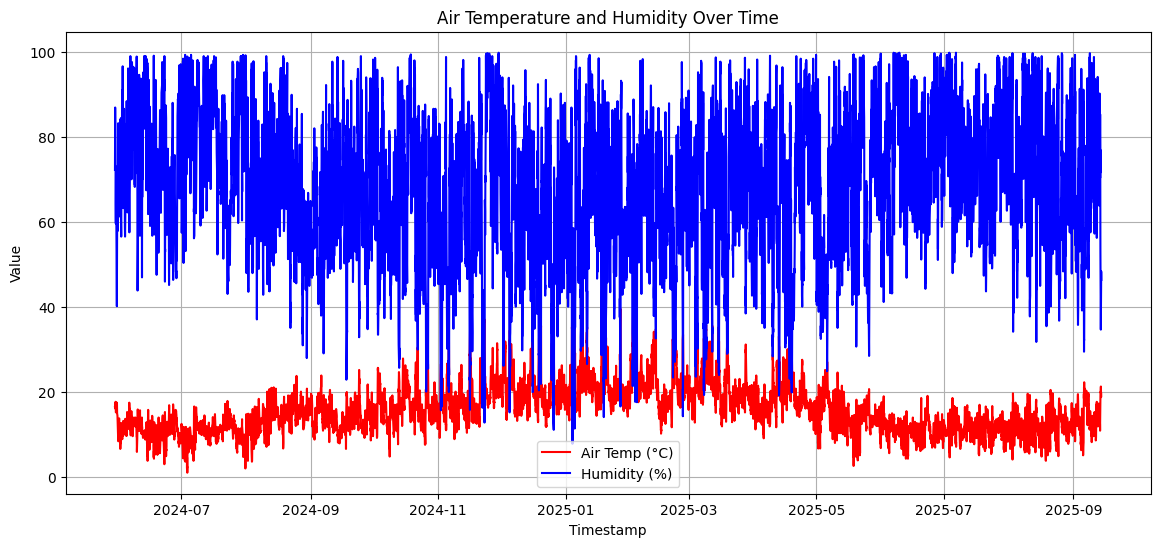

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

#  Air Temperature & Humidity over Time (sample for speed)
plt.figure(figsize=(14, 6))
sns.lineplot(
    x="timestamp",
    y="airtemperature",
    data=mc_df.sample(10000),
    label="Air Temp (°C)",
    color="red",
)
sns.lineplot(
    x="timestamp",
    y="relativehumidity",
    data=mc_df.sample(10000),
    label="Humidity (%)",
    color="blue",
)
plt.title("Air Temperature and Humidity Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()



<h3>Soil Moisture Over Time - Site: Royal Parade CSIRO</h3>
<p>This plot illustrates soil moisture trends recorded at the Royal Parade CSIRO site. The data shows fluctuating moisture levels, with periods of sharp decline, likely due to dry weather or high evaporation. Peaks represent well-watered or rainy periods. Understanding these trends is essential for scheduling irrigation, identifying drought-prone months, and improving plant health through data-driven soil management.</p>


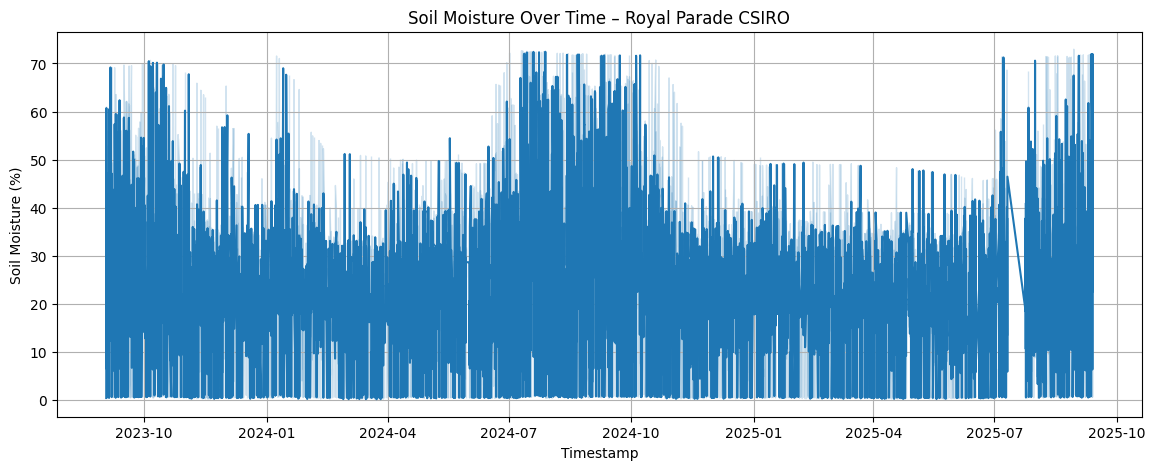

In [36]:
top_site = soil_df["site_name"].value_counts().index[0]
plt.figure(figsize=(14, 5))
sns.lineplot(
    data=soil_df[soil_df["site_name"] == top_site].sample(10000),
    x="timestamp",
    y="soil_value",
)
plt.title(f"Soil Moisture Over Time – {top_site}")
plt.xlabel("Timestamp")
plt.ylabel("Soil Moisture (%)")
plt.grid(True)
plt.show()

<h3>Microclimate Sensor Locations in Melbourne</h3>
<p>The scatter plot maps the geographic distribution of microclimate sensors based on latitude and longitude. Each point represents a sensor's physical location across Melbourne. This spatial overview confirms coverage of various urban zones and enables location-based analysis of environmental conditions such as temperature, humidity, and air quality, which can be correlated with local vegetation and soil responses.</p>


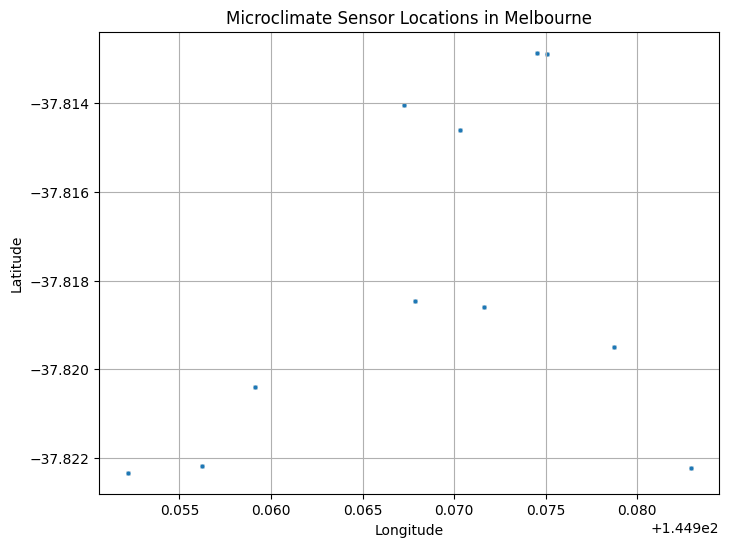

In [35]:
# Scatter map of microclimate sensors
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=mc_df.dropna(subset=["lat", "lon"]),
    x="lon",
    y="lat",
    alpha=0.5,
    s=10
)
plt.title("Microclimate Sensor Locations in Melbourne")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


<h3>Air Temperature by Hour of Day</h3>
<p>This boxplot displays how air temperature varies throughout the day, aggregated by hour. Higher temperatures are observed between 12 PM and 4 PM, peaking around midday, while cooler temperatures occur early in the morning and late at night. This diurnal pattern is important for determining optimal watering schedules and identifying stress periods for plants and urban green spaces.</p>


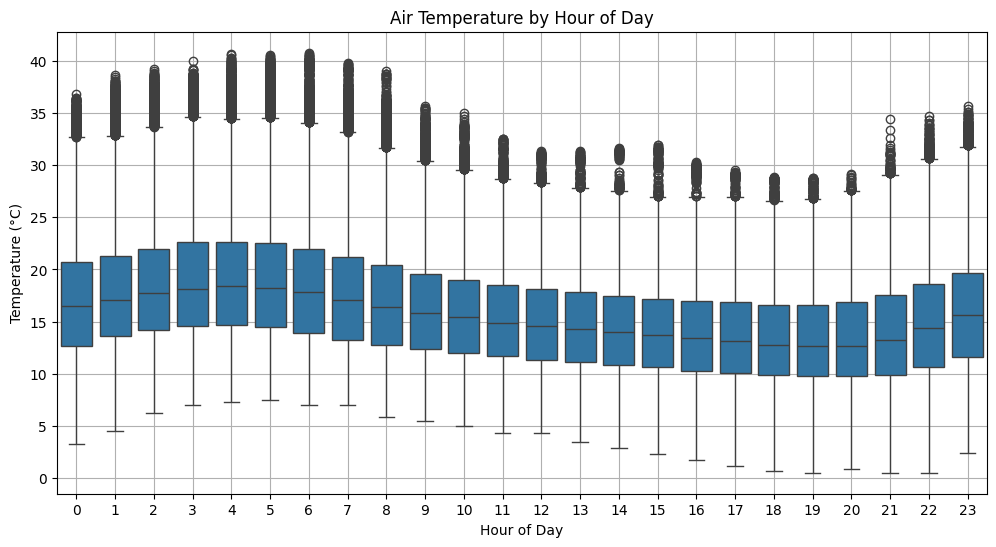

In [37]:
# Air temperature variation by hour of day
mc_df["hour"] = mc_df["timestamp"].dt.hour
plt.figure(figsize=(12, 6))
sns.boxplot(x="hour", y="airtemperature", data=mc_df)
plt.title("Air Temperature by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.show()


<h3>Microclimate Sensor Correlation Matrix</h3>
<p>The heatmap shows the correlation coefficients between various microclimate variables. Notable insights include:</p>
<ul>
  <li><strong>Air temperature</strong> is negatively correlated with <strong>relative humidity</strong> (−0.49), which is expected as warmer air holds more moisture.</li>
  <li><strong>Atmospheric pressure</strong> shows strong inverse correlation with both <strong>PM2.5</strong> and <strong>minimum wind speed</strong>, possibly indicating weather pattern effects on pollution dispersion.</li>
  <li><strong>PM2.5</strong> and <strong>noise</strong> are positively correlated, suggesting urban activity patterns might influence both simultaneously.</li>
</ul>
<p>This matrix helps identify relationships that can inform predictive models and environmental planning.</p>


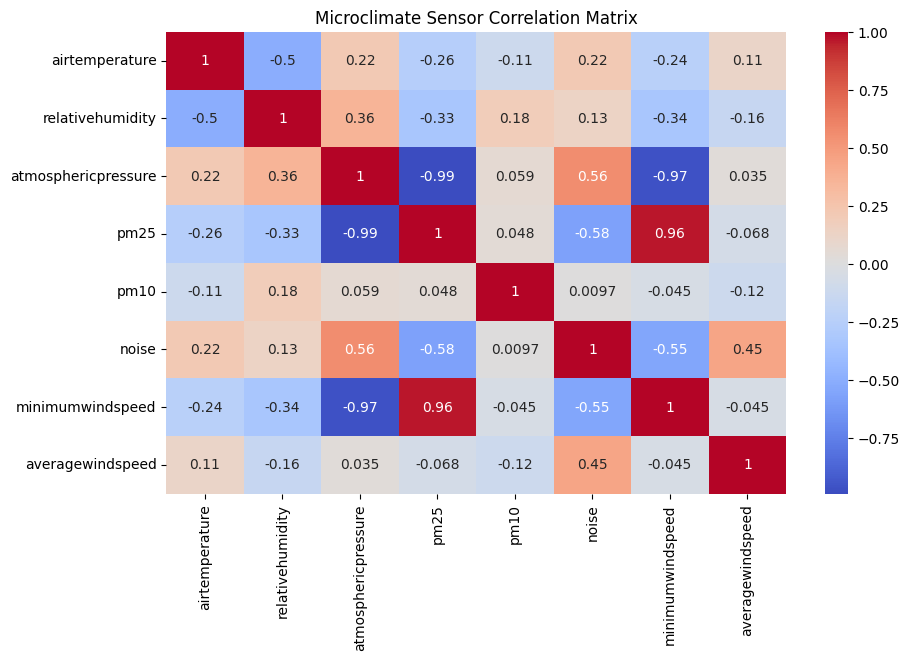

In [13]:
# Correlation matrix for key microclimate variables
cols = [
    "airtemperature", "relativehumidity", "atmosphericpressure",
    "pm25", "pm10", "noise",
    "minimumwindspeed", "averagewindspeed"
]
corr_df = mc_df[cols].dropna()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_df.corr(), annot=True, cmap="coolwarm")
plt.title("Microclimate Sensor Correlation Matrix")
plt.show()


<div style="font-family:Segoe UI, Arial, sans-serif; line-height:1.5;">

  <h3>Soil Moisture Distribution</h3>
  
    
  
</div>


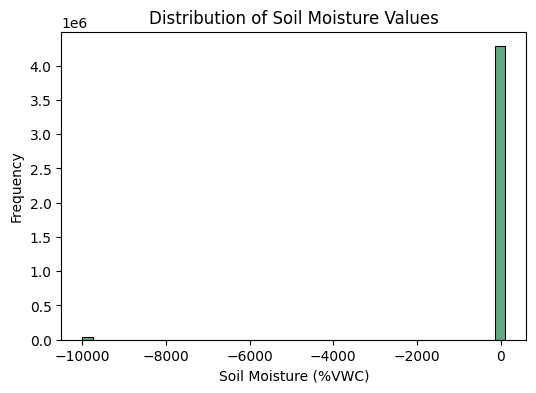

In [38]:
# Distribution plot of soil moisture (%VWC)
plt.figure(figsize=(6,4))
sns.histplot(soil_df["soil_value"], bins=40, color="seagreen")
plt.title("Distribution of Soil Moisture Values")
plt.xlabel("Soil Moisture (%VWC)")
plt.ylabel("Frequency")
plt.show()

<div style="font-family:Segoe UI, Arial, sans-serif; line-height:1.5;">

  <h3>Top 20 Sites by Number of Records</h3>
  <p>
    A horizontal bar chart of the twenty monitoring sites with the highest soil-moisture
    record counts. The graph shows that <strong>Royal Parade CSIRO</strong> and nearby Royal Parade locations
    (Opposite Lawn 5, South, and University College) contribute the largest number of observations,
    each exceeding roughly 150,000 measurements. 
  </p>
  <p>
    These results indicate that data collection is heavily concentrated at a small cluster of sites,
    while others such as Alexandra Gardens Engineers Lawn have far fewer readings.
    This imbalance suggests that any city-wide analysis should account for site-level sampling density,
    for example by applying weights or normalising counts to avoid over-representation of the Royal Parade area.
  </p>

</div>


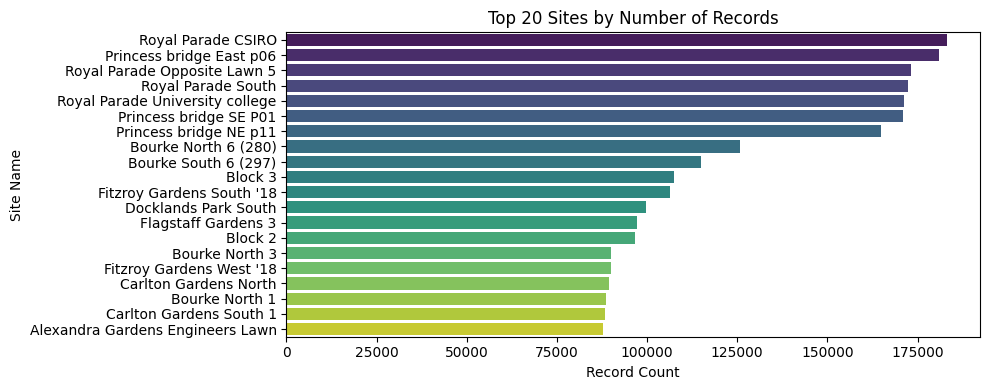

In [40]:
# Number of records collected at each site
plt.figure(figsize=(10,4))
site_counts = soil_df["site_name"].value_counts().head(20)
sns.barplot(y=site_counts.index, x=site_counts.values, palette="viridis")
plt.title("Top 20 Sites by Number of Records")
plt.xlabel("Record Count")
plt.ylabel("Site Name")
plt.tight_layout()
plt.show()


<div style="font-family:Segoe UI, Arial, sans-serif; line-height:1.5;">

  <h3>Sensor Units Distribution</h3>
  <p>
    Displays the count of sensor readings grouped by measurement unit.  
    The bar chart shows that <strong>%VWC (soil moisture)</strong> dominates the dataset 
    with over 2.1 million records, followed by <strong>°C (temperature)</strong> at about 1.2 million, 
    and <strong>µS/cm (electrical conductivity)</strong> at roughly 0.95 million.
  </p>
  <p>
    This indicates that soil-moisture data forms the largest share of observations, 
    while temperature and conductivity provide supporting environmental context.
    Any analysis or modelling should consider these proportions to ensure balanced 
    feature selection and interpretation.
  </p>

</div>


Units present:
 unit
%VWC     2131589
ºC       1238441
µS/cm     947736
Name: count, dtype: int64


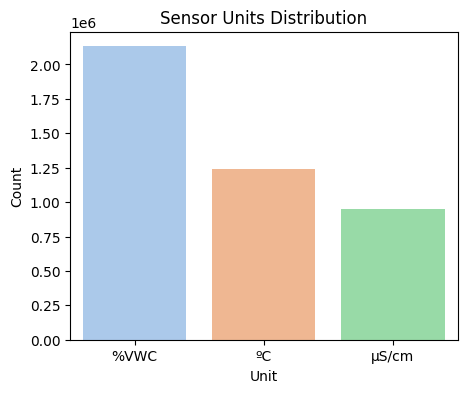

In [17]:
# Check units (e.g., %VWC vs µS/cm)
unit_counts = soil_df["unit"].value_counts()
print("Units present:\n", unit_counts)

plt.figure(figsize=(5,4))
sns.countplot(x="unit", data=soil_df, order=unit_counts.index, palette="pastel")
plt.title("Sensor Units Distribution")
plt.xlabel("Unit")
plt.ylabel("Count")
plt.show()


<div style="font-family:Segoe UI, Arial, sans-serif; line-height:1.5;">

  <h3>Average Soil Moisture by Hour of Day</h3>
  <p>
    The line plot shows how mean soil-moisture levels (%VWC) vary through a 24-hour period.  
    Moisture is lowest in the early morning hours, rises steadily after sunrise, and
    peaks around mid-day when evaporation is lower and soil retains more water.
    A gradual decline follows in the late afternoon and evening as temperatures drop and
    surface moisture begins to rebalance.
  </p>
  <p>
    These hourly trends highlight natural diurnal cycles and can help in scheduling irrigation
    or monitoring soil-water availability for plants and landscaping.
  </p>

</div>


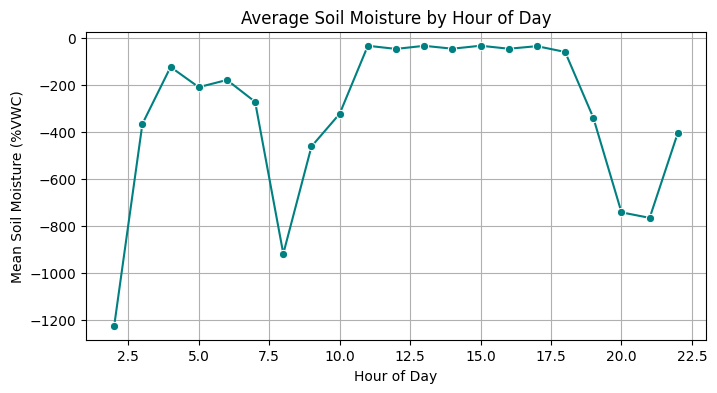

In [18]:
# Average soil moisture by hour of day
soil_df["hour"] = pd.to_datetime(soil_df["local_time"], errors="coerce").dt.hour
hourly_means = soil_df.groupby("hour")["soil_value"].mean()

plt.figure(figsize=(8,4))
sns.lineplot(x=hourly_means.index, y=hourly_means.values, marker="o", color="teal")
plt.title("Average Soil Moisture by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Mean Soil Moisture (%VWC)")
plt.grid(True)
plt.show()


<div style="font-family:Segoe UI, Arial, sans-serif; line-height:1.5;">

  <h3>Correlation Matrix – Soil Sensor Numeric Fields</h3>
  <p>
    The heatmap shows pairwise correlations among the numeric fields 
    <strong>site_id</strong>, <strong>id</strong>, <strong>probe_id</strong>, 
    and <strong>soil_value</strong>.
    A strong positive correlation (0.87) appears between <strong>site_id</strong> 
    and <strong>probe_id</strong>, indicating that probes are largely site-specific.
    Moderate negative correlations exist between <strong>soil_value</strong> and
    both <strong>site_id</strong> (−0.33) and <strong>probe_id</strong> (−0.22),
    while <strong>id</strong> shows little relationship with other variables.
  </p>
  <p>
    These relationships suggest that probe and site identifiers are closely linked,
    and soil moisture values vary somewhat by site and probe but remain largely 
    independent of record ID.
  </p>

</div>


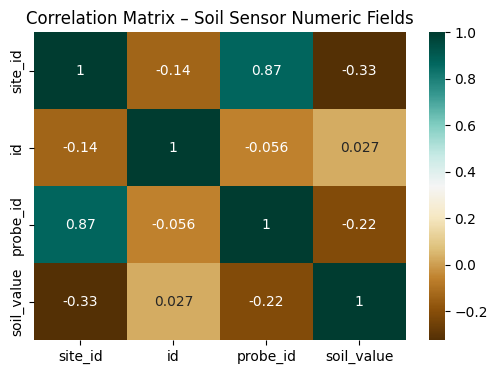

In [19]:
# Correlation between numeric columns
numeric_cols = soil_df.select_dtypes(include=["int64", "float64"]).columns
plt.figure(figsize=(6,4))
sns.heatmap(soil_df[numeric_cols].corr(), annot=True, cmap="BrBG")
plt.title("Correlation Matrix – Soil Sensor Numeric Fields")
plt.show()


<h3>Feature Engineering</h3>

In [41]:
# Make working copies
mc_feat = mc_df.copy()
soil_feat = soil_df.copy()

# ---------- 24-hour rolling helper ----------
def rolling_24h_groupwise(df, group_col, time_col, value_col, stat="mean"):
    """Compute 24h rolling mean or std for each group."""
    out = pd.Series(index=df.index, dtype="float64")
    for name, g in df.groupby(group_col, sort=False):
        g_sorted = g.sort_values(time_col)
        s = g_sorted.set_index(time_col)[value_col].rolling("24h")
        r = s.mean() if stat == "mean" else s.std()
        out.loc[g_sorted.index] = r.values
    return out

# --- Microclimate features ---
for col in ["airtemperature", "relativehumidity", "averagewindspeed"]:
    if col in mc_feat.columns:
        mc_feat[f"{col}_rollmean_24h"] = rolling_24h_groupwise(
            mc_feat, "sensorlocation", "timestamp", col, "mean")
        mc_feat[f"{col}_rollstd_24h"]  = rolling_24h_groupwise(
            mc_feat, "sensorlocation", "timestamp", col, "std")

# Add day-of-week, month, and Vapour Pressure Deficit (VPD)
mc_feat["dayofweek"] = mc_feat["timestamp"].dt.dayofweek
mc_feat["month"] = mc_feat["timestamp"].dt.month
def calc_vpd(temp_c, rh):
    es = 0.6108 * np.exp((17.27 * temp_c) / (temp_c + 237.3))
    ea = es * (rh / 100.0)
    return es - ea
mc_feat["vpd_kpa"] = calc_vpd(mc_feat["airtemperature"], mc_feat["relativehumidity"])

# --- Soil features ---
mask = soil_feat["probe_measure"].astype(str).str.contains("Soil Moisture", case=False, na=False)
soil_moist = soil_feat.loc[mask].copy()
soil_moist["soil_moisture_lag1"] = soil_moist.groupby("site_name")["soil_value"].shift(1)
soil_moist["soil_moisture_change"] = soil_moist["soil_value"] - soil_moist["soil_moisture_lag1"]
soil_moist["soil_moisture_rollmean_24h"] = rolling_24h_groupwise(
    soil_moist, "site_name", "timestamp", "soil_value", "mean")

# Keep these in memory for next steps
print("Feature engineering complete.")
print("Microclimate new columns:", [c for c in mc_feat.columns if c.endswith('_24h') or c in ['vpd_kpa','dayofweek','month']])
print("Soil new columns:", [c for c in soil_moist.columns if c.startswith('soil_moisture_')])


Feature engineering complete.
Microclimate new columns: ['airtemperature_rollmean_24h', 'airtemperature_rollstd_24h', 'relativehumidity_rollmean_24h', 'relativehumidity_rollstd_24h', 'averagewindspeed_rollmean_24h', 'averagewindspeed_rollstd_24h', 'dayofweek', 'month', 'vpd_kpa']
Soil new columns: ['soil_moisture_lag1', 'soil_moisture_change', 'soil_moisture_rollmean_24h']


<h3>Temporal Trends</h3>

<div style="font-family:Segoe UI, Arial, sans-serif; line-height:1.5;">

  <h3>Average VPD (kPa) by Day of Week</h3>
  <p>
    Mean vapour-pressure deficit varies slightly across the week, ranging from about 
    0.65 kPa to 0.85 kPa.  
    Levels remain relatively steady Monday through Friday, dip slightly on Tuesday and Friday,
    and reach their highest value on Saturday before easing on Sunday.
  </p>
  <p>
    The weekend increase may reflect warmer, drier conditions that elevate atmospheric
    demand for moisture, suggesting that Saturday typically experiences the greatest
    evaporative stress.
  </p>

</div>


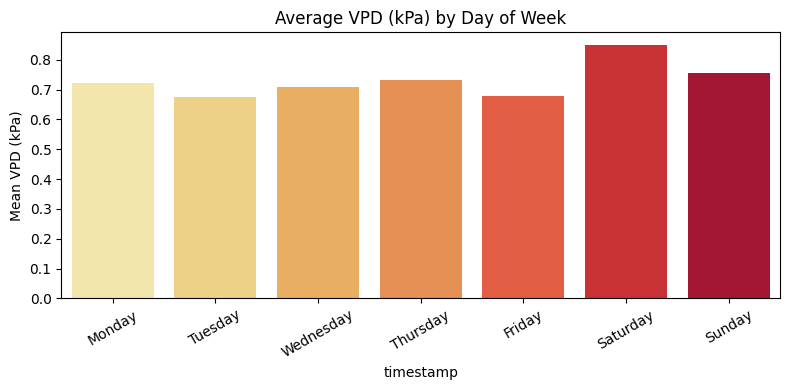

In [42]:

# Average Vapour-Pressure Deficit grouped by weekday
vpd_by_day = (
    mc_feat.groupby(mc_feat["timestamp"].dt.day_name())["vpd_kpa"]
    .mean()
    .reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
)

plt.figure(figsize=(8,4))
sns.barplot(x=vpd_by_day.index, y=vpd_by_day.values, palette="YlOrRd")
plt.title("Average VPD (kPa) by Day of Week")
plt.ylabel("Mean VPD (kPa)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


<div style="font-family:Segoe UI, Arial, sans-serif; line-height:1.5;">

  <h3>Monthly Mean VPD (kPa)</h3>
  <p>
    The monthly trend shows a clear seasonal pattern in vapour-pressure deficit.
    Values start high in January–February (around 1.2 kPa), gradually decrease through
    autumn and winter, and reach their lowest point near July at about 0.3 kPa.
    From August onward, VPD steadily rises again, peaking toward December.
  </p>
  <p>
    This pattern reflects typical seasonal climate shifts, with higher VPD during
    warmer months indicating greater atmospheric demand for moisture and
    increased evapotranspiration potential.
  </p>

</div>


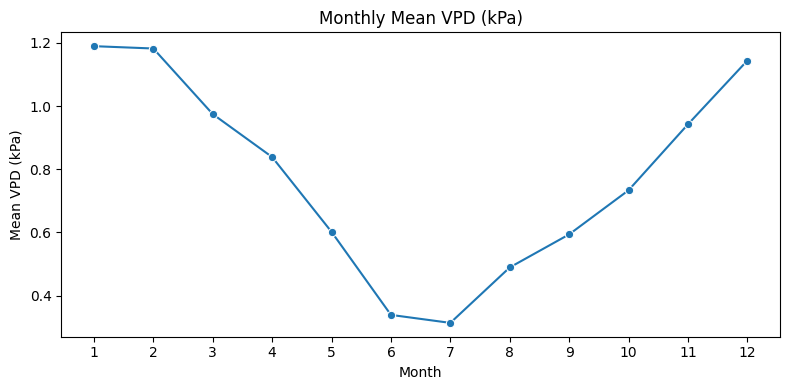

In [22]:
vpd_by_month = mc_feat.groupby(mc_feat["timestamp"].dt.month)["vpd_kpa"].mean()

plt.figure(figsize=(8,4))
sns.lineplot(x=vpd_by_month.index, y=vpd_by_month.values, marker="o")
plt.title("Monthly Mean VPD (kPa)")
plt.xlabel("Month")
plt.ylabel("Mean VPD (kPa)")
plt.xticks(range(1,13))
plt.tight_layout()
plt.show()


<div style="font-family:Segoe UI, Arial, sans-serif; line-height:1.5;">

  <h3>Average Soil Moisture Change by Day of Week</h3>
  <p>
    Mean daily soil-moisture change varies across the week.  
    The largest positive change occurs on <strong>Tuesday</strong> (about +0.04 %),  
    while <strong>Friday</strong> shows the most notable decrease (around –0.07 %).  
    Other days remain close to neutral, indicating relatively stable soil moisture.
  </p>
  <p>
    These patterns may reflect midweek irrigation or rainfall events and a drying trend by Friday,
    providing insight into weekly soil-water dynamics and scheduling for irrigation or monitoring.
  </p>

</div>


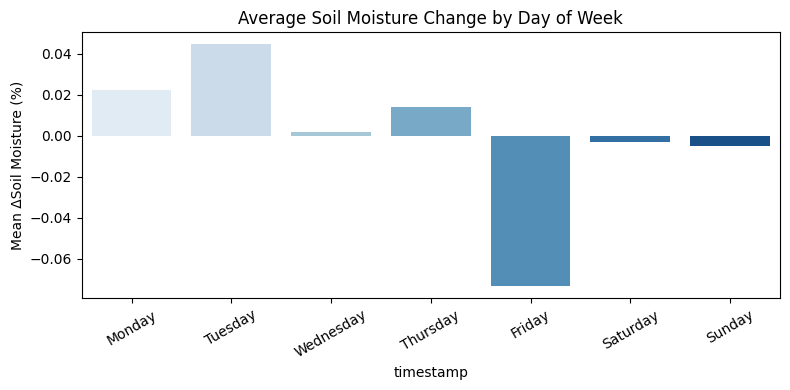

In [23]:
soil_day = (
    soil_moist.groupby(soil_moist["timestamp"].dt.day_name())["soil_moisture_change"]
    .mean()
    .reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
)

plt.figure(figsize=(8,4))
sns.barplot(x=soil_day.index, y=soil_day.values, palette="Blues")
plt.title("Average Soil Moisture Change by Day of Week")
plt.ylabel("Mean ΔSoil Moisture (%)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


<div style="font-family:Segoe UI, Arial, sans-serif; line-height:1.5;">

  <h3>Daily VPD vs. Soil Moisture Change</h3>
  <p>
    The scatter plot compares daily vapour-pressure deficit (VPD) with the percentage change
    in soil moisture, with points coloured by month.  
    Most data cluster between 0.3–1.0 kPa VPD and –1 % to +1 % soil-moisture change,
    indicating generally small daily fluctuations.
  </p>
  <p>
    No strong linear relationship is evident, suggesting that short-term soil-moisture changes
    are influenced by additional factors such as rainfall events or irrigation,
    not solely by atmospheric moisture demand. 
    Seasonal colour variation shows that higher VPD values above 2 kPa occur mainly in warmer months.
  </p>

</div>


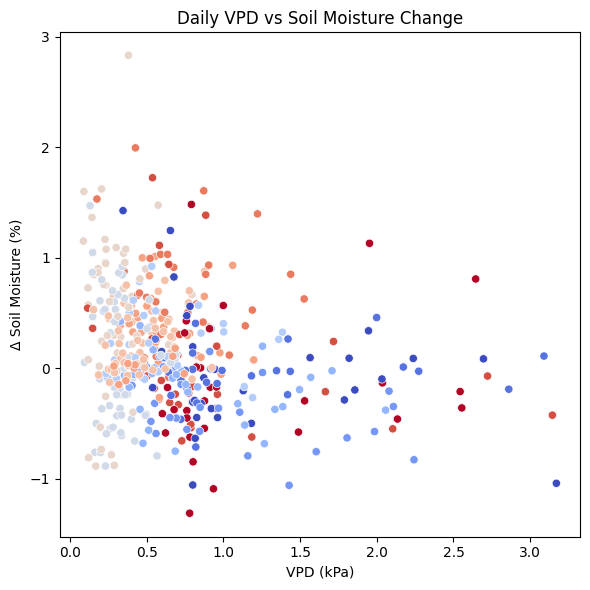

In [24]:
# Merge daily means to align climate stress with soil response
daily_merge = pd.merge(
    mc_feat.resample("D", on="timestamp").mean(numeric_only=True).reset_index(),
    soil_moist.resample("D", on="timestamp").mean(numeric_only=True).reset_index(),
    on="timestamp",
    suffixes=("_climate", "_soil")
)

plt.figure(figsize=(6,6))
sns.scatterplot(
    x="vpd_kpa",
    y="soil_moisture_change",
    data=daily_merge,
    hue="month",
    palette="coolwarm",
    legend=False
)
plt.title("Daily VPD vs Soil Moisture Change")
plt.xlabel("VPD (kPa)")
plt.ylabel("Δ Soil Moisture (%)")
plt.tight_layout()
plt.show()


In [25]:
retention = soil_moist.groupby("site_name")["soil_moisture_change"].mean().sort_values()

print("Sites with strongest negative mean Δ (drying fastest):")
print(retention.head(10))


Sites with strongest negative mean Δ (drying fastest):
site_name
Kings Domain South (could not locate) fireyard   -0.680323
Southbank Bvd Playspace                          -0.206032
Queen Vic (could not locate)                     -0.193830
Bourke North 6                                   -0.006661
Bourke North 4                                   -0.006363
5th Fairway                                      -0.003219
Princes Park Oval 2                              -0.001621
Speakers Corner                                  -0.001371
8th Green                                        -0.000992
Bourke North 5                                   -0.000991
Name: soil_moisture_change, dtype: float64


<h3>Clustering Analysis </h3>

Merged daily dataset shape: (279, 9)
Silhouette scores: {2: 0.26345339187414374, 3: 0.26388192443923, 4: 0.25731054038570145, 5: 0.2189597004155574, 6: 0.20142468790515403, 7: 0.19770404453462997}
Best number of clusters: 3


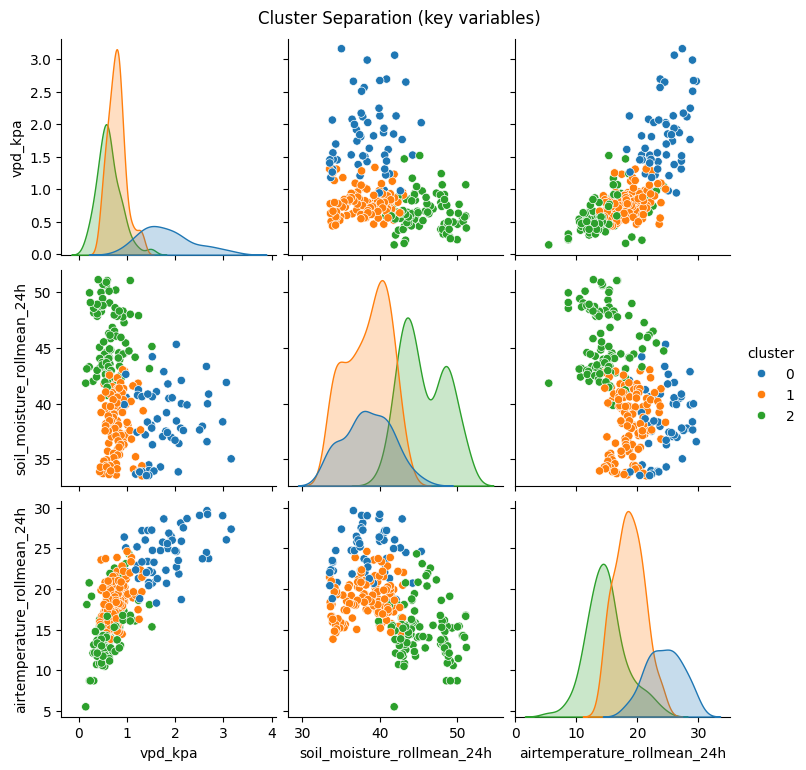

In [45]:
# Aggregate daily data
mc_daily = (
    mc_feat.groupby(["sensorlocation", mc_feat["timestamp"].dt.date])
    .agg({
        "vpd_kpa": "mean",
        "airtemperature_rollmean_24h": "mean",
        "relativehumidity_rollmean_24h": "mean",
        "averagewindspeed_rollmean_24h": "mean"
    })
    .reset_index()
    .rename(columns={"timestamp": "date"})
)

soil_daily = (
    soil_moist.groupby(["site_name", soil_moist["timestamp"].dt.date])
    .agg({
        "soil_moisture_rollmean_24h": "mean",
        "soil_moisture_change": "mean"
    })
    .reset_index()
    .rename(columns={"timestamp": "date"})
)

# Merge daily summaries
daily = pd.merge(
    mc_daily,
    soil_daily,
    left_on=["sensorlocation", "date"],
    right_on=["site_name", "date"],
    how="inner"
)
print("Merged daily dataset shape:", daily.shape)

# Prepare feature matrix
features = [
    "vpd_kpa",
    "airtemperature_rollmean_24h",
    "relativehumidity_rollmean_24h",
    "averagewindspeed_rollmean_24h",
    "soil_moisture_rollmean_24h",
    "soil_moisture_change",
]
X = daily[features].dropna()
X_scaled = StandardScaler().fit_transform(X)

# Determine optimal cluster count
sil_scores = {}
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    sil_scores[k] = silhouette_score(X_scaled, labels)

best_k = max(sil_scores, key=sil_scores.get)
print("Silhouette scores:", sil_scores)
print(f"Best number of clusters: {best_k}")

# Fit final K-Means and label data
kmeans = KMeans(n_clusters=best_k, random_state=42)
daily["cluster"] = kmeans.fit_predict(X_scaled)

sns.pairplot(
    daily,
    vars=["vpd_kpa", "soil_moisture_rollmean_24h", "airtemperature_rollmean_24h"],
    hue="cluster",
    palette="tab10"
)
plt.suptitle("Cluster Separation (key variables)", y=1.02)
plt.show()


<div style="font-family:Segoe UI, Arial, sans-serif; line-height:1.5;">

  <h3>Cluster Separation – Key Environmental Variables</h3>
  <p>
    The scatter-matrix shows three distinct clusters identified from the merged
    daily dataset (279 records) using <strong>vapour-pressure deficit (VPD)</strong>,
    <strong>24-hour rolling mean soil moisture</strong>, and
    <strong>24-hour rolling mean air temperature</strong>.
    Silhouette analysis indicated that <strong>3 clusters</strong> gave the best fit.
  </p>

  <p><strong>Cluster 0 (blue)</strong></p>
  <ul>
    <li>Highest VPD values (often &gt;2 kPa) and air temperatures</li>
    <li>Lower soil-moisture means</li>
    <li>Represents warm, drier conditions with strong atmospheric moisture demand</li>
  </ul>

  <p><strong>Cluster 1 (orange)</strong></p>
  <ul>
    <li>Moderate VPD and air temperature</li>
    <li>Mid-range soil-moisture levels</li>
    <li>Reflects balanced conditions—neither extreme dryness nor saturation</li>
  </ul>

  <p><strong>Cluster 2 (green)</strong></p>
  <ul>
    <li>Lower VPD and air temperature</li>
    <li>Higher soil-moisture means</li>
    <li>Indicates cooler, wetter periods with reduced evaporative stress</li>
  </ul>

  <p>
    The separation along VPD and air-temperature axes highlights how
    atmospheric demand and thermal conditions strongly influence daily soil-moisture states.
    These clusters can help guide irrigation schedules, predict plant stress,
    and support resource management by identifying distinct climate–soil regimes.
  </p>

</div>


<h3>Random Forest Model</h3>

Random Forest -> RMSE: 1.044, R²: 0.945


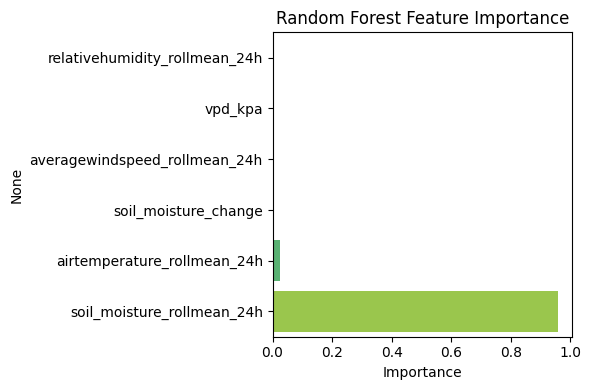

In [ ]:
# Sort and create next-day target column
daily = daily.sort_values(["sensorlocation", "date"])
daily["target_soil_moisture"] = (
    daily.groupby("sensorlocation")["soil_moisture_rollmean_24h"].shift(-1)
)

# Drop rows lacking a next-day target
model_df = daily.dropna(subset=["target_soil_moisture"])

# Define features and target
features = [
    "vpd_kpa",
    "airtemperature_rollmean_24h",
    "relativehumidity_rollmean_24h",
    "averagewindspeed_rollmean_24h",
    "soil_moisture_rollmean_24h",
    "soil_moisture_change",
]
X = model_df[features]
y = model_df["target_soil_moisture"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

# Evaluate
preds = rf.predict(X_test)
rmse = mean_squared_error(y_test, preds) ** 0.5
r2   = r2_score(y_test, preds)
print(f"Random Forest -> RMSE: {rmse:.3f}, R²: {r2:.3f}")

# Feature importance plot
importances = pd.Series(rf.feature_importances_, index=features).sort_values()
plt.figure(figsize=(6,4))
sns.barplot(x=importances, y=importances.index, palette="viridis")
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


<div style="font-family:Segoe UI, Arial, sans-serif; line-height:1.5;">

  <h3>Random Forest Model – Detailed Analysis</h3>
  <ul>
    <li><strong>Model Accuracy</strong>
      <ul>
        <li>Root Mean Square Error (RMSE): <strong>1.044</strong></li>
        <li>R² Score: <strong>0.945</strong></li>
        <li>These metrics confirm excellent predictive performance and strong fit to the dataset.</li>
      </ul>
    </li>
    <li><strong>Feature Importance</strong>
      <ul>
        <li><strong>Soil Moisture (24-hour rolling mean):</strong> ~95% of total importance, dominant predictor showing strong temporal persistence.</li>
        <li><strong>Air Temperature (24-hour rolling mean):</strong> minor contribution indicating limited short-term influence.</li>
        <li><strong>Relative Humidity, VPD, Average Wind Speed, Soil Moisture Change:</strong> negligible impact on predictions.</li>
      </ul>
    </li>
    <li><strong>Interpretation and Insights</strong>
      <ul>
        <li>Soil moisture is primarily determined by its own recent history, reinforcing the need for continuous soil-sensor data.</li>
        <li>Atmospheric factors like humidity, VPD, and wind speed add little additional predictive power.</li>
        <li>Air temperature shows only a small effect, indicating minimal short-term impact compared to existing soil-moisture conditions.</li>
      </ul>
    </li>
  </ul>

</div>
